# Анализ факторов, влияющих на успешность компьютерных игр

*Целью работы является выявление закономерностей, определяющих успешность игры по данным из открытых источников для планирования стратегии продаж в интернет-магазине «Стримчик».*

### Описание данных games.csv

**Name** — название игры<br>**Platform** — платформа<br> 
**Year_of_Release** — год выпуска<br> 
**Genre** — жанр игры<br> 
**NA_sales** — продажи в Северной Америке (миллионы долларов)<br> 
**EU_sales** — продажи в Европе (миллионы долларов)<br> 
**JP_sales** — продажи в Японии (миллионы долларов)<br> 
**Other_sales** — продажи в других странах (миллионы долларов)<br> 
**Critic_Score** — оценка критиков (от 0 до 100)<br> 
**User_Score** — оценка пользователей (от 0 до 10)<br> 
**Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Этап 1. Получение данных

Импортируем нужные библиотеки. Загрузим датасет и посмотрим на данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
url = 'https://code.s3.yandex.net/datasets/games.csv'

In [3]:
data = pd.read_csv(url)
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные загружены, но, как мы видим уже с первых строк, в них есть пропуски. Странно выглядит и столбец с годом выпуска. На следующем этапе подготовим данные к анализу.

## Этап 2. Подготовка данных

Посмотрим на типы данных и количество записей.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating есть пропуски. Пропуски в столбце с названием выглядят как техническая накладка, поскольку имя является в этих данных идентификатором игры. Так как таких записей всего 2, их можно удалить. Для этих же записей пропущены значения жанра (код запроса в ячейке ниже). Похоже, что-то пошло не так на этапе сбора данных. 

In [5]:
data.query('Name.isnull()', engine='python')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Непонятно, чем вызваны пропуски в столбце Year_of_Release, их тоже относительно немного - 269. Возможно, нам не потребуются данные за все время, поэтому пока оставляем пропуски как есть. 

Critic_Score и User_Score могут быть незаполнены по объективным причинам: в открытом источнике, из которого мы берем данные, может не быть оценок критиков, поскольку учитываются не все отзывы на игру, а, например, только часть авторитетных журналов.   

Рейтинг ESRB - необязательная возрастная маркировка, которую издатели игры получают самостоятельно, то есть ее может и не быть, пропуски в столбце не выглядят аномалией. 

Для удобства дальнейшей работы приведем названия столбцов к нижнему регистру.

In [6]:
data.set_axis([c.lower() for c in data.columns.values],axis='columns',inplace=True)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

В столбце name всего 2 пропущенных значения и по другим данным в таблице их не восстановить, поэтому удалим строки с ними.

In [7]:
data.dropna(subset = ['name'], inplace = True) 

Приведем к типу дата столбец year_of_release.

In [8]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y')

Аббревиатура 'tbd' означает, что рейтинг неизвестен, поэтому заменим его NaN

In [9]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Создадим новый столбец total_sales - суммарные продажи во всех регионах

In [10]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Таким образом мы привели данные к верному типу и обработали пропуски. Можно приступать к анализу

## Этап 3. Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

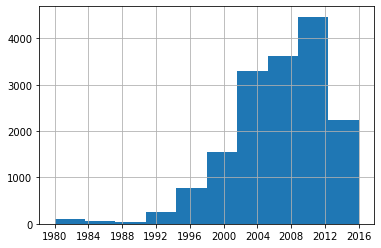

In [11]:
data['year_of_release'].hist()

По гистограмме заметен спад выпусков игр в 2012-2016. Это может быть последствием мирового экономического кризиса, начавшегося в 2008. Кроме того, возможно произошло насыщение рынка. Также свою роль могло сыграть появление и широкое распространение других устройств, на которых можно играть в игры - смартфоны, планшеты, смарт-тв. 

Посмотрим, для каких платформ суммарные продажи максимальны

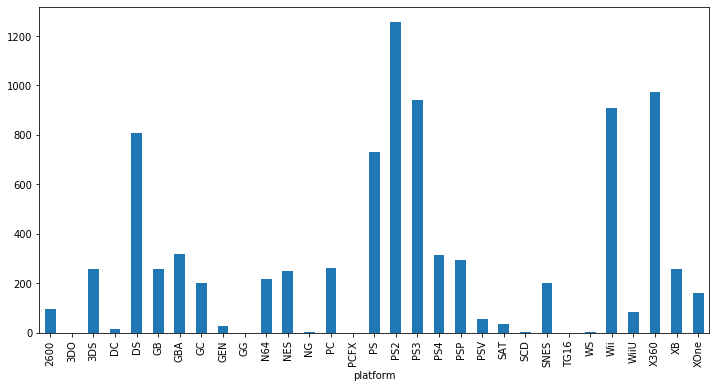

In [12]:
data.groupby('platform')['total_sales'].sum().plot(figsize=(12, 6), kind="bar")

По графику видно, что суммарные продажи максимальны для платформ PS2, X360, PS3, Wii. Посмотрим распределение продаж для этих платформ по годам

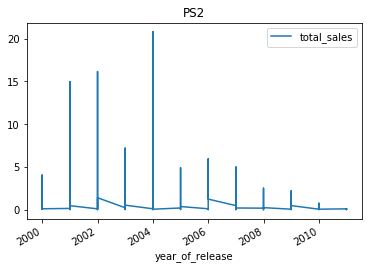

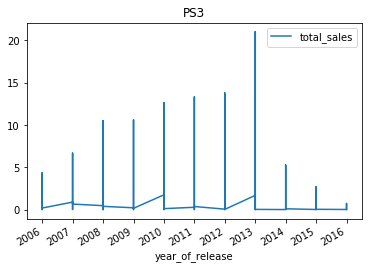

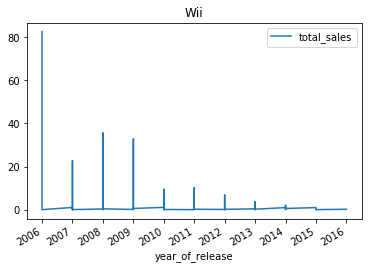

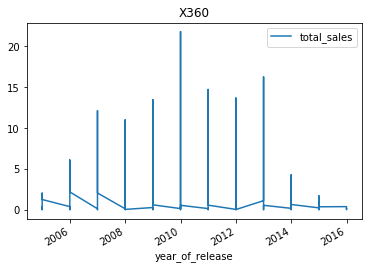

In [13]:
for p in ["PS2", "PS3", "Wii", "X360"]:
    sample = data.query('platform == @p')
    sample.plot(x='year_of_release', y='total_sales', title=p)

По графикам заметно, что со временем продажи для каждой платформы падают.

Вычислим среднюю продолжительность существования платформ: сгруппируем данные по платформам, найдем разницу между первым годом выходом игры на этой платформе и последним

In [14]:
platforms = data.groupby('platform')['year_of_release'].max().dt.year - data.groupby('platform')['year_of_release'].min().dt.year

In [15]:
print('Средняя продолжительность существования платформы в годах:', 
    round(platforms.mean(), 1))

Средняя продолжительность существования платформы в годах: 7.6


Построим график продолжительности существования платформ

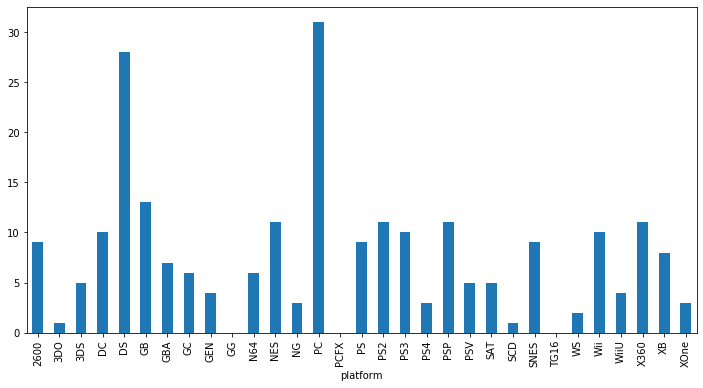

In [16]:
platforms.plot(kind="bar", figsize=(12, 6))

Видно, что есть платформы, существующие гораздо дольше среднего. При этом продажи игр для популярных в прошлом платформ, например, Wii - падают с течением времени. Поэтому имеет смысл рассматривать данные за предыдущие 2-3 года.

In [17]:
data_year = data.query('year_of_release > 2014')

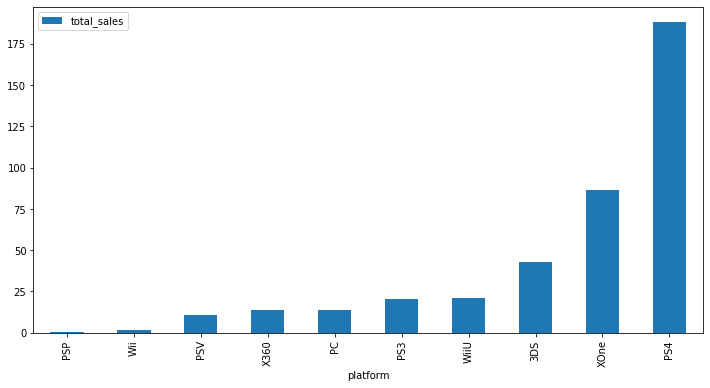

In [18]:
data_year.pivot_table('total_sales', index='platform', aggfunc='sum').sort_values(by='total_sales').plot(kind="bar", figsize=(12, 6))

По выборке данных за 2 года видно, что потенциально прибыльные платформы - PS4, XOne, 3DS

Построим диаграммы размаха с разбивкой по платформам актуального периода

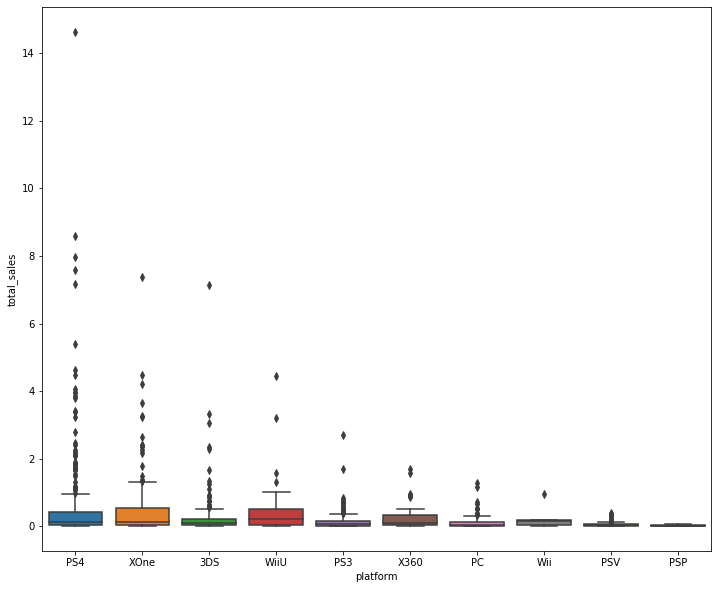

In [19]:
plt.figure(figsize=(12,10))
sns.boxplot(x="platform", y="total_sales", data=data_year)


Видим, что почти для всех платформ имеются выбросы, в том числе и для перспективных, которые мы выделили на предыдущем шаге. Исследуем, как влияют на продажи игр другие факторы. 

Посмотрим, как влияют отзывы критиков и пользователей на продажи внутри одной платформы для самых популярных платформ и выведем на график коэффициент корреляции между оценкой и продажами 

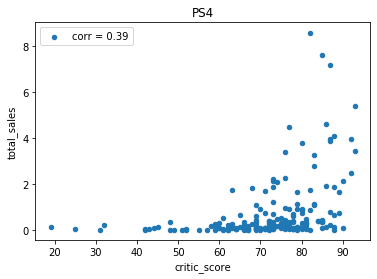

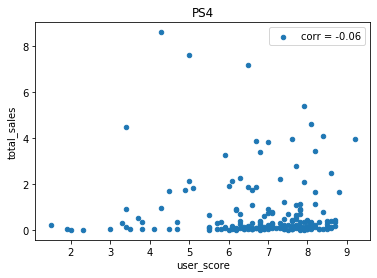

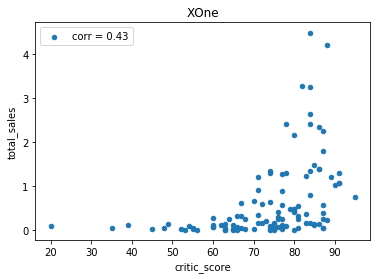

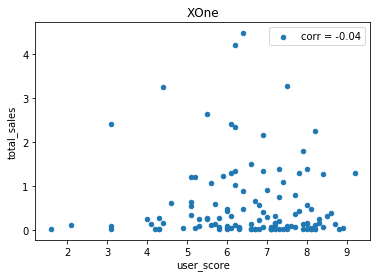

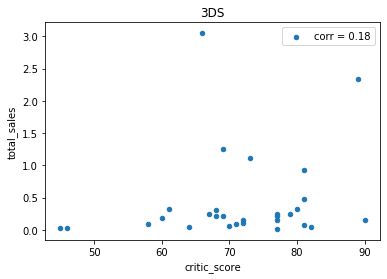

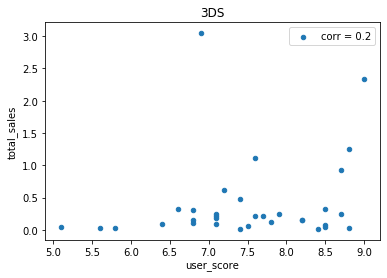

In [20]:
 for p in ["PS4", "XOne", "3DS"]:
    data_ps = data_year.query('platform == @p')
    data_ps.plot(x='critic_score', y='total_sales', kind='scatter', title=p, label='corr = ' + str(round(data_ps['total_sales'].corr(data_ps['critic_score']),2))) 
    data_ps.plot(x='user_score', y='total_sales', kind='scatter', title=p, label='corr = ' + str(round(data_ps['total_sales'].corr(data_ps['user_score']),2))) 

Судя по коэффициенту корреляции связь между отзывами и продажами не сильная.

Близкий к нулю коэффициент корреляции между оценкой критиков/пользователей и продажами для отдельной платформы говорит о том, что между этими переменными нет линейной зависимости. Если взаимосвязь существует, то более сложная.

Посмотрим на распределение продаж по жанрам

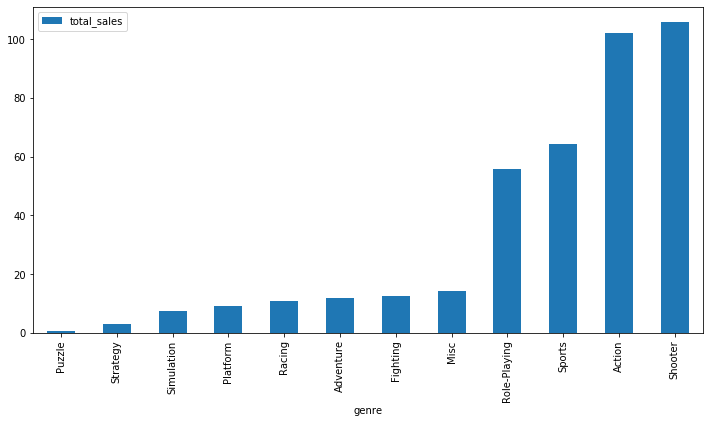

In [21]:
data_year.pivot_table('total_sales', index='genre', aggfunc='sum').sort_values(by='total_sales').plot(kind="bar", figsize=(12, 6))

Видно, что самые прибыльные жанры - Shooter и Action, а наименьшим спросом пользуются паззлы и стратегии.

## Этап 4. Портрет пользователя по регионам

Выведем топ-5 жанров по регионам

In [22]:
for reg in ['na_sales', 'eu_sales', 'jp_sales']:
    print(data_year.groupby('genre')[reg].sum().sort_values(ascending=False).head(5))
    print()

genre
Shooter         48.18
Action          33.68
Sports          26.31
Role-Playing    19.82
Misc             5.58
Name: na_sales, dtype: float64

genre
Shooter         40.28
Action          34.82
Sports          27.82
Role-Playing    17.21
Racing           6.52
Name: eu_sales, dtype: float64

genre
Action          23.05
Role-Playing    13.41
Shooter          3.79
Misc             3.19
Adventure        2.22
Name: jp_sales, dtype: float64



Выведем топ-5 платформ по регионам

platform
PS4     63.86
XOne    50.30
3DS     10.31
WiiU     8.86
X360     8.05
Name: na_sales, dtype: float64

platform
PS4     83.54
XOne    28.10
PC       9.10
3DS      7.39
PS3      7.30
Name: eu_sales, dtype: float64

platform
3DS     23.55
PS4     12.05
PSV      8.41
PS3      4.97
WiiU     4.12
Name: jp_sales, dtype: float64



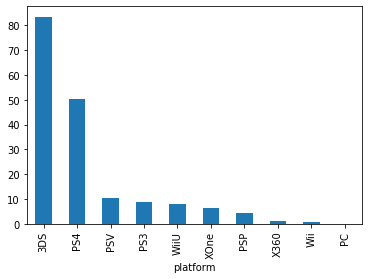

In [27]:
for reg in ['na_sales', 'eu_sales', 'jp_sales']:
    print(data_year.groupby('platform')[reg].sum().sort_values(ascending=False).head(5))
    print()

Популярные платформы и жанры в Европе и Северной Америке совпадают, но совершенно другая картина наблюдается в Японии. 

Японский рынок сильно отличается от других по ряду причин. Долгое время Япония была закрытой страной, до сих пор сильны традиции, поэтому большим спросом пользуется продукция местных компаний. Для игр это Nintendo (платформа 3DS) и Sony (PS). Кроме того, мобильные игры в Японии развиваются с 1999 года, так что потребители привыкли к определенному качеству. Также есть трудности с локализацией игр.


In [24]:
for reg in ['na_sales', 'eu_sales', 'jp_sales']:
    print(data_year.groupby('rating')[reg].sum().sort_values(ascending=False))
    print()

rating
M       47.03
E       26.59
T       22.86
E10+    17.87
Name: na_sales, dtype: float64

rating
M       45.54
E       34.83
T       20.32
E10+    11.54
Name: eu_sales, dtype: float64

rating
T       7.70
E       5.25
M       4.29
E10+    3.27
Name: jp_sales, dtype: float64



Как видно, рейтинг ESRB также не влияет на продажи на японском рынке, а для Европы и Северной Америки картины похожи.  

## Этап 5. Исследование статистических показателей

Выведем среднее пользовательского рейтинга и рейтинга критиков в различных жанрах

In [31]:
data_year.groupby('genre')['critic_score'].mean()

genre
Action          71.040541
Adventure       74.821429
Fighting        72.100000
Misc            74.200000
Platform        75.157895
Puzzle          76.000000
Racing          72.740741
Role-Playing    76.860000
Shooter         75.672414
Simulation      68.250000
Sports          70.153846
Strategy        77.562500
Name: critic_score, dtype: float64

In [32]:
data_year.groupby('genre')['user_score'].mean()

genre
Action          6.808290
Adventure       7.685294
Fighting        6.886957
Misc            6.658333
Platform        6.245000
Puzzle          7.766667
Racing          6.610714
Role-Playing    7.772727
Shooter         6.388710
Simulation      6.515789
Sports          5.198780
Strategy        7.268750
Name: user_score, dtype: float64

На основании средних рейтингов можно сформулировать некоторые гипотезы о популярности игр разных жанров, которые будут проверены на следующем этапе.

## Этап 6. Проверка гипотез

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [33]:
alpha = 0.05 
results = st.ttest_ind (data_year.query('platform == "XOne"')['user_score'].dropna(), data_year.query('platform == "PC"')['user_score'].dropna(), equal_var = True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.2778542084733835
Не получилось отвергнуть нулевую гипотезу


Проверим гипотезу: средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.

In [34]:
results = st.ttest_ind (data_year.query('genre == "Action"')['user_score'].dropna(), data_year.query('genre == "Sports"')['user_score'].dropna(), equal_var = True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  1.0012846807938657e-13
Отвергаем нулевую гипотезу


## Этап 7. Выводы

В работе были проанализированы различные факторы, влияющие на продажи игр по данным из открытых источников. Данные для анализа были предварительно обработаны - заполнены пропущенные значения, приведены к правильному типу. 

В результате анализа были получены средняя продолжительность существования игровых платформ - 7,6 лет и наиболее популярные платформы на 2016 год - PS4, XOne, 3DS.

Также были составлен портрет пользователя игр в разных регионах и проанализированы популярные жанры - Европе, Северной Америке и Японии. Замечено, что японский рынок сильно отличается от остальных. Самые прибыльные жанры - Shooter и Action, а наименьшим спросом пользуются паззлы и стратегии. 